In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

batch_size = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
trainloader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True,
                   transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size, shuffle=True
)


print(f"训练集样本数：{len(trainloader.dataset)}")  
print(f"测试集样本数：{len(testloader.dataset)}")   

训练集样本数：60000
测试集样本数：10000


In [3]:
class Net(nn.Module): 
    def __init__(self): 
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)  
        self.conv2 = nn.Conv2d(6, 16, 5)            

        self.fc1 = nn.Linear(5*5*16, 120)  
        self.fc2 = nn.Linear(120, 84)       
        self.clf = nn.Linear(84, 10)        

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)

        x = F.sigmoid(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)

        x = x.view(x.size(0), -1) 

        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.clf(x)
        
        return x

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)  
epochs = 30  

print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (clf): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
for epoch in range(epochs): 
    accs, losses = [], [] 
    for batch_idx, (x, y) in enumerate(trainloader): 
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad() 
        out = model(x)         
        loss = F.cross_entropy(out, y)  
        loss.backward()     
        optimizer.step()    
    
    correct = 0
    testloss = 0
    with torch.no_grad(): 
        for batch_idx, (x, y) in enumerate(testloader):
            x, y = x.to(device), y.to(device) 
            out = model(x) 
            testloss += F.cross_entropy(out, y).item()  
            pred = out.max(dim=1, keepdim=True)[1]       
            correct += pred.eq(y.view_as(pred)).sum().item() 

    acc = correct / len(testloader.dataset) 
    testloss = testloss / (batch_idx + 1) 
    accs.append(acc) 
    losses.append(testloss)

    print('epoch:{}, loss:{:.4f}, acc:{:.4f}'.format(epoch, testloss, acc))

epoch:0, loss:1.4298, acc:0.4460
epoch:1, loss:0.3233, acc:0.9003
epoch:2, loss:0.1975, acc:0.9374
epoch:3, loss:0.1073, acc:0.9668
epoch:4, loss:0.0880, acc:0.9721
epoch:5, loss:0.0626, acc:0.9814
epoch:6, loss:0.0625, acc:0.9804
epoch:7, loss:0.0584, acc:0.9809
epoch:8, loss:0.0493, acc:0.9848
epoch:9, loss:0.0490, acc:0.9860
epoch:10, loss:0.0460, acc:0.9855
epoch:11, loss:0.0541, acc:0.9827
epoch:12, loss:0.0478, acc:0.9853
epoch:13, loss:0.0429, acc:0.9858
epoch:14, loss:0.0508, acc:0.9856
epoch:15, loss:0.0408, acc:0.9870
epoch:16, loss:0.0386, acc:0.9883
epoch:17, loss:0.0369, acc:0.9887
epoch:18, loss:0.0533, acc:0.9823
epoch:19, loss:0.0352, acc:0.9891
epoch:20, loss:0.0373, acc:0.9890
epoch:21, loss:0.0450, acc:0.9869
epoch:22, loss:0.0404, acc:0.9885
epoch:23, loss:0.0399, acc:0.9880
epoch:24, loss:0.0398, acc:0.9884
epoch:25, loss:0.0381, acc:0.9887
epoch:26, loss:0.0422, acc:0.9889
epoch:27, loss:0.0398, acc:0.9890
epoch:28, loss:0.0399, acc:0.9884
epoch:29, loss:0.0421, a

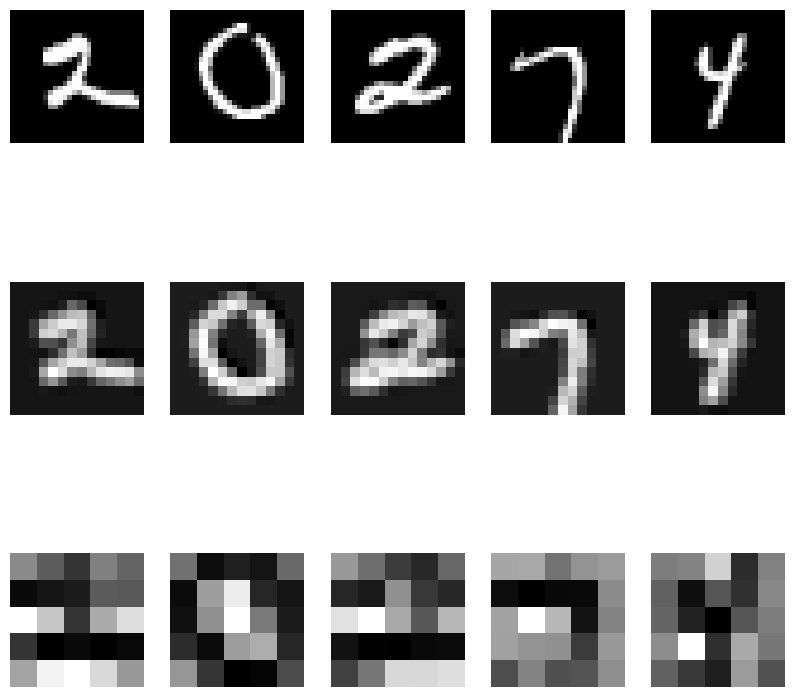

In [5]:
feature1 = F.sigmoid(model.conv1(x))
feature1 = F.avg_pool2d(feature1, kernel_size=2, stride=2)
feature2 = F.sigmoid(model.conv2(feature1))
feature2 = F.avg_pool2d(feature2, kernel_size=2, stride=2)

n=5  
img = x.detach().cpu().numpy()[:n]  
feature_map1 = feature1.detach().cpu().numpy()[:n]
feature_map2 = feature2.detach().cpu().numpy()[:n]

fig, ax = plt.subplots(3, n, figsize=(10, 10)) 
for i in range(n):
    ax[0,i].axis('off')
    ax[0,i].imshow(img[i].sum(0),cmap='gray') 
    ax[1,i].axis('off')
    ax[1,i].imshow(feature_map1[i].sum(0),cmap='gray')
    ax[2,i].axis('off')
    ax[2, i].imshow(feature_map2[i].sum(0),cmap='gray')

plt.show()  